In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from tensorflow.keras.optimizers import Nadam
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_count = 0
labels = []
train_counts = []
for dirname in os.listdir('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train'):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train',dirname)):
        image_count +=1
    train_counts.append(image_count)

print(list(zip(train_counts,labels)))

[(354, 'glass'), (286, 'metal'), (403, 'paper'), (287, 'cardboard'), (347, 'plastic'), (91, 'trash')]


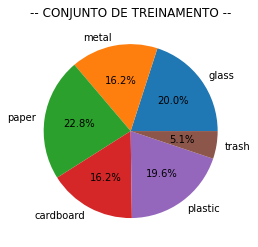

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=labels,
        autopct='%1.1f%%');
plt.title('-- CONJUNTO DE TREINAMENTO --');

In [ ]:
class_weights = []
total_samples = train_generator.samples              
total_classes = len(train_generator.class_indices)   
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)
print(dict(zip(labels,class_weights)))

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))

{'glass': 0.83, 'metal': 1.03, 'paper': 0.73, 'cardboard': 1.03, 'plastic': 0.85, 'trash': 3.24}


In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                  )

# Note that the validation data should not be augmented!
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 8 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train',
                                                    batch_size =8,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))     

# Flow validation images in batches of 4 using valid_datagen generator
validation_generator =  valid_datagen.flow_from_directory( '/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/valid',
                                                          batch_size  = 4,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150,150))     

# Flow test images using test_datagen generator
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/test',
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  target_size = (150,150),shuffle = False)     

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


# Xception Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

xception_model = keras.applications.xception.Xception(weights="imagenet",
                                                      include_top=False,
                                                      input_shape = (150,150,3))
avg = keras.layers.GlobalAveragePooling2D()(xception_model.output)
output = keras.layers.Dense(6, activation="softmax")(avg)
model = keras.models.Model(inputs=xception_model.input, outputs=output)

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer =optimizer ,loss = 'categorical_crossentropy',metrics =['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.7,patience = 2)
model_checkpoint =tf.keras.callbacks.ModelCheckpoint('GarbageClassifier_Xce.h5', save_best_only=True)

class CustomCallBack(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>0.98):
                print("\nReached 98.0% accuracy so cancelling training!")
                self.model.stop_training = True
                
mycallback = CustomCallBack()

In [ ]:
gpu_name = tf.test.gpu_device_name()
if gpu_name != '/device:GPU:0':
  raise SystemError('no GPUs')
print('GPUs found: {}'.format(gpu_name))

GPUs found: /device:GPU:0


In [ ]:
def train_gpu():
  with tf.device('/device:GPU:0'):
    model_history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs = 30,
            validation_data = validation_generator,
            validation_steps= validation_generator.samples/validation_generator.batch_size,
            class_weight = class_weights ,
            callbacks= [early_stopping_cb,model_checkpoint,lr_scheduler,mycallback],
            verbose=1)
  return model_history
model_history = train_gpu()

Epoch 1/30
221/221 [==============================] - 452s 2s/step - loss: 1.6050 - accuracy: 0.4277 - val_loss: 6.2544 - val_accuracy: 0.2927
Epoch 2/30
221/221 [==============================] - 24s 107ms/step - loss: 1.4312 - accuracy: 0.4807 - val_loss: 1.0919 - val_accuracy: 0.6159
Epoch 3/30
221/221 [==============================] - 24s 106ms/step - loss: 1.1793 - accuracy: 0.5818 - val_loss: 0.9019 - val_accuracy: 0.7226
Epoch 4/30
221/221 [==============================] - 23s 106ms/step - loss: 1.0259 - accuracy: 0.6332 - val_loss: 1.6178 - val_accuracy: 0.6250
Epoch 5/30
221/221 [==============================] - 24s 107ms/step - loss: 0.9564 - accuracy: 0.6522 - val_loss: 1.2675 - val_accuracy: 0.5671
Epoch 6/30
221/221 [==============================] - 24s 107ms/step - loss: 0.8576 - accuracy: 0.6954 - val_loss: 0.9672 - val_accuracy: 0.6707
Epoch 7/30
221/221 [==============================] - 24s 107ms/step - loss: 0.7400 - accuracy: 0.7561 - val_loss: 0.8020 - val_accu

No handles with labels found to put in legend.


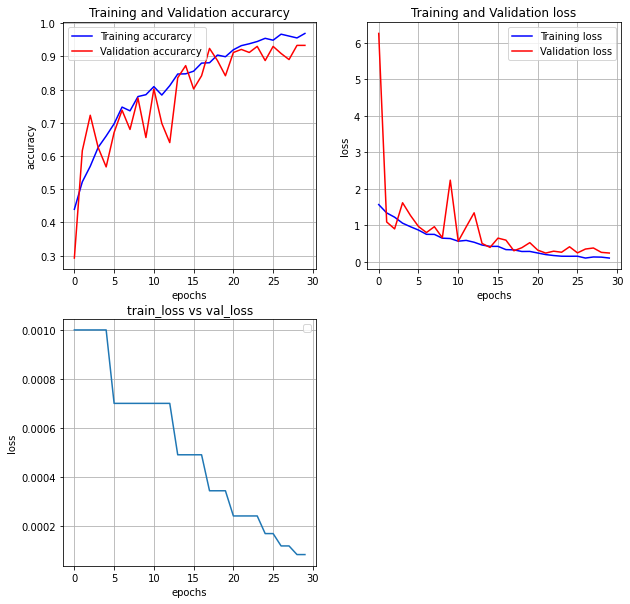

In [ ]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(model_history.history['accuracy'],'b-', label = "Training accurarcy")
plt.plot(model_history.history['val_accuracy'], 'r-', label = "Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(model_history.history['loss'],'b-', label = "Training loss")
plt.plot(model_history.history['val_loss'], 'r-', label = "Validation loss")
plt.title("Training and Validation loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(model_history.epoch,model_history.history['lr'],'-')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

In [ ]:
model.evaluate(test_generator,batch_size = 1) 

431/431 [==============================] - 87s 202ms/step - loss: 0.2447 - accuracy: 0.9350


[0.2447325736284256, 0.9350348114967346]

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        70
           1       0.96      0.87      0.91        82
           2       0.92      0.99      0.95        68
           3       0.96      0.94      0.95       108
           4       0.94      0.91      0.92        74
           5       0.80      0.97      0.88        29

    accuracy                           0.94       431
   macro avg       0.92      0.94      0.93       431
weighted avg       0.94      0.94      0.94       431



Text(0.5, 1.0, 'Confusion matrix of model')

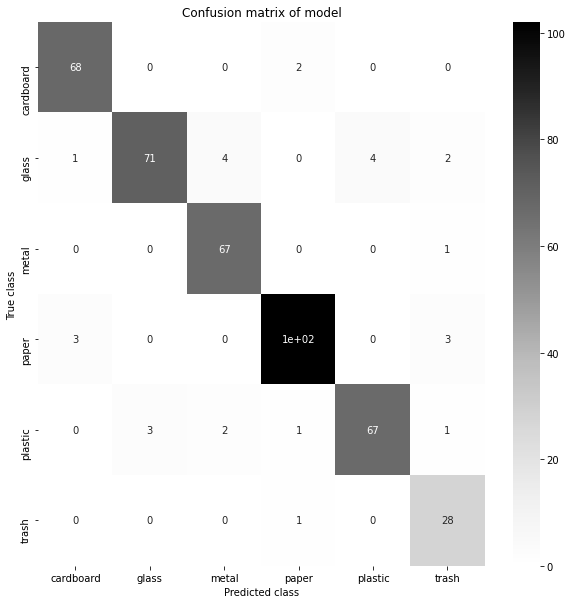

In [ ]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, cmap="Greys")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

# MODEL 2

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

xception_model = keras.applications.xception.Xception(weights="imagenet",
                                                      include_top=False,
                                                      input_shape = (150,150,3))
avg = keras.layers.GlobalAveragePooling2D()(xception_model.output)
output = keras.layers.Dense(6, activation="softmax")(avg)
model2 = keras.models.Model(inputs=xception_model.input, outputs=output)

In [ ]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model2.compile(optimizer =optimizer ,loss = 'categorical_crossentropy',metrics =['accuracy'])

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.001, s=10)



early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
mc =tf.keras.callbacks.ModelCheckpoint('XceptionLR_Xce2exp.h5', save_best_only=True)
class CustomCallBack(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>0.99):
                print("\nReached 99.0% accuracy so cancelling training!")
                self.model.stop_training = True

In [ ]:
def train_gpu():
  with tf.device('/device:GPU:0'):
    model1_history = model2.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs = 30,
            validation_data = validation_generator,
            validation_steps= validation_generator.samples/validation_generator.batch_size,
            callbacks= [early_stopping_cb,mc,lr_scheduler,mycallback],
            verbose=1)
  return model1_history
model1_history = train_gpu()

Epoch 1/30
221/221 [==============================] - 36s 111ms/step - loss: 1.4238 - accuracy: 0.4459 - val_loss: 1.6586 - val_accuracy: 0.6220
Epoch 2/30
221/221 [==============================] - 24s 108ms/step - loss: 1.0368 - accuracy: 0.6332 - val_loss: 0.8797 - val_accuracy: 0.6860
Epoch 3/30
221/221 [==============================] - 24s 106ms/step - loss: 0.8642 - accuracy: 0.6977 - val_loss: 0.6622 - val_accuracy: 0.7744
Epoch 4/30
221/221 [==============================] - 24s 107ms/step - loss: 0.6775 - accuracy: 0.7708 - val_loss: 0.7006 - val_accuracy: 0.7896
Epoch 5/30
221/221 [==============================] - 24s 107ms/step - loss: 0.5572 - accuracy: 0.8039 - val_loss: 0.5221 - val_accuracy: 0.8415
Epoch 6/30
221/221 [==============================] - 24s 107ms/step - loss: 0.5099 - accuracy: 0.8304 - val_loss: 0.3641 - val_accuracy: 0.8811
Epoch 7/30
221/221 [==============================] - 24s 108ms/step - loss: 0.4452 - accuracy: 0.8430 - val_loss: 0.3043 - val_ac

No handles with labels found to put in legend.


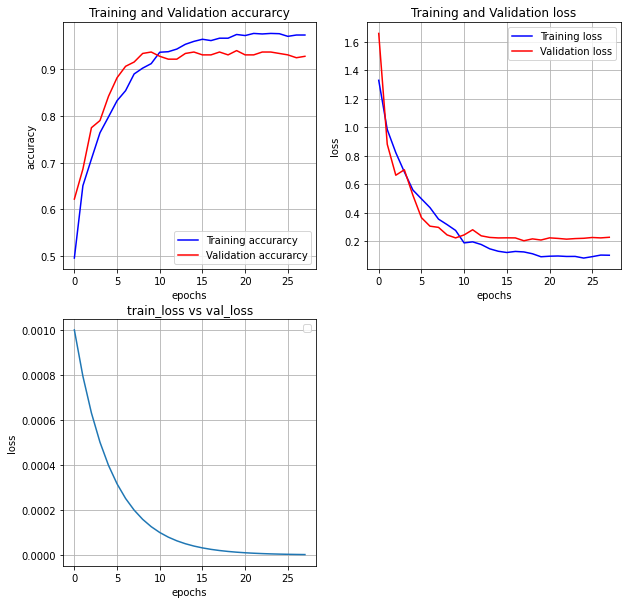

In [ ]:

fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(model1_history.history['accuracy'],'b-', label = "Training accurarcy")
plt.plot(model1_history.history['val_accuracy'], 'r-', label = "Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(model1_history.history['loss'],'b-', label = "Training loss")
plt.plot(model1_history.history['val_loss'], 'r-', label = "Validation loss")
plt.title("Training and Validation loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(model1_history.epoch,model1_history.history['lr'],'-')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

In [ ]:
model2.evaluate(test_generator,batch_size = 1)

431/431 [==============================] - 4s 9ms/step - loss: 0.2238 - accuracy: 0.9350


[0.22383099794387817, 0.9350348114967346]

In [ ]:
test_generator.class_indices.keys()

dict_keys(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        70
           1       0.93      0.90      0.91        82
           2       0.92      0.96      0.94        68
           3       0.94      0.98      0.96       108
           4       0.93      0.91      0.92        74
           5       0.93      0.86      0.89        29

    accuracy                           0.94       431
   macro avg       0.93      0.93      0.93       431
weighted avg       0.94      0.94      0.93       431



Text(0.5, 1.0, 'Confusion matrix of model')

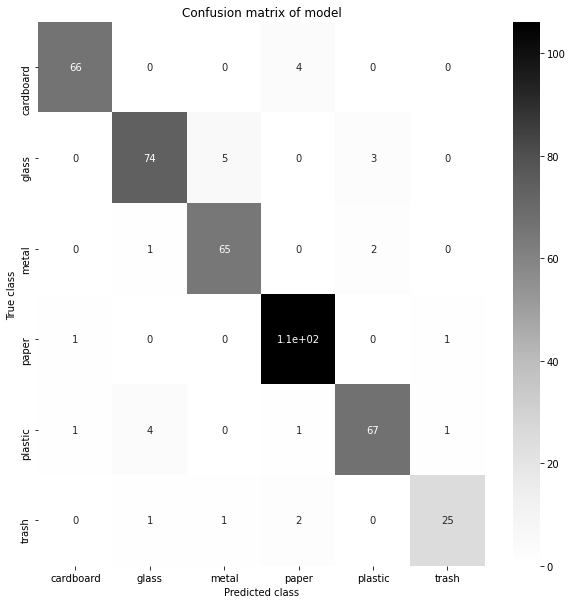

In [ ]:
y_pred = model2.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, cmap="Greys")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')